## Notebook that Generates All Tables For Classifier Performance Bucket 1

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import os, glob

### Test Set Performance

In [3]:
import pdb
from sklearn.metrics import roc_auc_score

def test_load_predictions(df):
    """
    Reads in output of df, computes AUROC for each classifier and asserts that it equals the AUROC
    listed in the auroc.txt file associate with the classfier's directory
    """
    base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}"
    abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]
    for abx in abx_options:
        path = base_path.format(abx=abx)
        f_auroc = os.path.join(path, 'auroc.txt')
        with open(f_auroc, 'r') as f:
            auroc = round(float(f.read()), 3)
        
        computed_auroc = round(roc_auc_score(df['%s_label' % abx], df['%s_predictions' % abx]), 3)
        
        try:
            assert auroc == computed_auroc
        except:
            pdb.set_trace()
        print("%s_auroc: %s"% (abx, str(auroc)))

def load_predictions():
    """Helper function that loads predictions from AST classifiers for test set data"""
    
    base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}"
    abx_options = ["Vancomycin",
                   "Ampicillin",
                   "Cefazolin",
                   "Ceftriaxone",
                   "Cefepime",
                   "Zosyn",
                   "Ciprofloxacin",
                   "Meropenem",
                   "Vancomycin_Meropenem",
                   "Vancomycin_Zosyn",
                   "Vancomycin_Cefepime",
                   "Vancomycin_Ceftriaxone"
                   ]
    df = pd.DataFrame()
    for i, abx in enumerate(abx_options):
        path = base_path.format(abx=abx)
        f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
        if i == 0:
            df = pd.read_csv(f_path)
            df = df[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df = df.rename(columns={'label' : '%s_label' % abx,
                                    'predictions' : '%s_predictions' % abx})
        else:
            df_preds = pd.read_csv(f_path)
            df_preds = df_preds[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df_preds = df_preds.rename(columns={'label' : '%s_label' % abx,
                                                'predictions' : '%s_predictions' % abx})
            df = df.merge(df_preds, how='left', on=['anon_id', 'pat_enc_csn_id_coded'])
    
    return df
    
df = load_predictions()
test_load_predictions(df)

Vancomycin_auroc: 0.717
Ampicillin_auroc: 0.621
Cefazolin_auroc: 0.674
Ceftriaxone_auroc: 0.688
Cefepime_auroc: 0.649
Zosyn_auroc: 0.641
Ciprofloxacin_auroc: 0.611
Meropenem_auroc: 0.685
Vancomycin_Meropenem_auroc: 0.731
Vancomycin_Zosyn_auroc: 0.699
Vancomycin_Cefepime_auroc: 0.697
Vancomycin_Ceftriaxone_auroc: 0.669


In [1]:
# Create Table with bootstrapped 95% CI intervals for auroc and average precision

In [4]:
def bootstrapped_performance(labels, predictions):
    """Given labels and predictions, bootstraps auroc and average precision
       and returns mean values along with 95%ci range for both of them"""
    
    aurocs,  average_precisions = [], []
    inds = [i for i in range(len(labels))]
    for i in range(1000):
        inds_boot = np.random.choice(inds, size=len(inds), replace=True)
        labels_b = labels[inds_boot]
        predictions_b = predictions[inds_boot]
        aurocs.append(roc_auc_score(labels_b, predictions_b))
        average_precisions.append(average_precision_score(labels_b, predictions_b))
    
    mean_auc = np.mean(aurocs)
    auc_low = np.percentile(aurocs, 2.5)
    auc_high = np.percentile(aurocs, 97.5)
    auroc = "%.2f [%.2f, %.2f]" % (mean_auc, auc_low, auc_high)
    
    mean_ap = np.mean(average_precisions)
    ap_low = np.percentile(average_precisions, 2.5)
    ap_high = np.percentile(average_precisions, 97.5)
    average_precision = "%.2f [%.2f, %.2f]" % (mean_ap, ap_low, ap_high)
    
    prev = str(round(np.average(labels), 2))
    
    return auroc, average_precision, prev


df_test_results = pd.DataFrame()
abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]

df_test_results['Antibiotic Selection'] = [a for a in abx_options]


base_path = "/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}"
best_model_classes = []
prevs = []
aps = []
aurocs = []
for abx in abx_options:
    path = base_path.format(abx=abx)
    f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
    best_model_class = f_path.split('/')[-1].split('_')[0]
    best_model_classes.append(best_model_class)
    auroc, ap, prev = bootstrapped_performance(df['%s_label' % abx].values,
                                               df['%s_predictions' % abx].values)
    prevs.append(prev)
    aps.append(ap)
    aurocs.append(auroc)
df_test_results['Best Model Class'] = best_model_classes
df_test_results['Positive Class Prevalence'] = prevs
df_test_results['Average Precision'] = aps
df_test_results['AUROC'] = aurocs

In [5]:
df_test_results.head()

,Antibiotic Selection,Best Model Class,Positive Class Prevalence,Average Precision,AUROC
0,Vancomycin,lightgbm,0.23,"0.46 [0.40, 0.52]","0.72 [0.69, 0.75]"
1,Ampicillin,lightgbm,0.43,"0.54 [0.50, 0.58]","0.62 [0.59, 0.65]"
2,Cefazolin,lightgbm,0.59,"0.72 [0.69, 0.76]","0.67 [0.64, 0.70]"
3,Ceftriaxone,lightgbm,0.66,"0.80 [0.76, 0.82]","0.69 [0.66, 0.72]"
4,Cefepime,random,0.8,"0.87 [0.85, 0.89]","0.65 [0.61, 0.68]"


In [ ]:
df_test_results = df_test_results.sort_values('Positive Class Prevalence')

In [ ]:
df_test_results.to_csv("Table 3: Bucket 1 Classifier Results.csv", index=None)

### Create Precision recall curves for each classifier  

In [6]:
df.head()

,anon_id,pat_enc_csn_id_coded,Vancomycin_label,Vancomycin_predictions,Ampicillin_label,Ampicillin_predictions,Cefazolin_label,Cefazolin_predictions,Ceftriaxone_label,Ceftriaxone_predictions,...,Meropenem_label,Meropenem_predictions,Vancomycin_Meropenem_label,Vancomycin_Meropenem_predictions,Vancomycin_Zosyn_label,Vancomycin_Zosyn_predictions,Vancomycin_Cefepime_label,Vancomycin_Cefepime_predictions,Vancomycin_Ceftriaxone_label,Vancomycin_Ceftriaxone_predictions
0,JC2a03b24,131260812263,0,0.108161,0,0.462078,0,0.664275,1,0.798270,...,1,0.896608,1,0.987670,1,0.964979,1,0.961668,1,0.871461
1,JCe45a3c,131260883970,1,0.483241,1,0.538177,0,0.631024,0,0.784364,...,0,0.883272,1,0.987744,1,0.966207,1,0.970636,1,0.904466
2,JCd235bb,131261001599,0,0.215610,0,0.501686,1,0.631382,1,0.653581,...,1,0.815785,1,0.988870,1,0.965573,1,0.956648,1,0.897293
3,JCd29af0,131261001696,0,0.321022,0,0.351406,0,0.459186,0,0.424984,...,1,0.554059,1,0.980191,1,0.947425,1,0.948773,0,0.805817
4,JCd356bf,131261014293,1,0.421153,1,0.412029,1,0.528823,1,0.724792,...,1,0.839434,1,0.954408,1,0.963848,1,0.946225,1,0.840946


In [8]:
abx_options

['Vancomycin',
 'Ampicillin',
 'Cefazolin',
 'Ceftriaxone',
 'Cefepime',
 'Zosyn',
 'Ciprofloxacin',
 'Meropenem',
 'Vancomycin_Meropenem',
 'Vancomycin_Zosyn',
 'Vancomycin_Cefepime',
 'Vancomycin_Ceftriaxone']

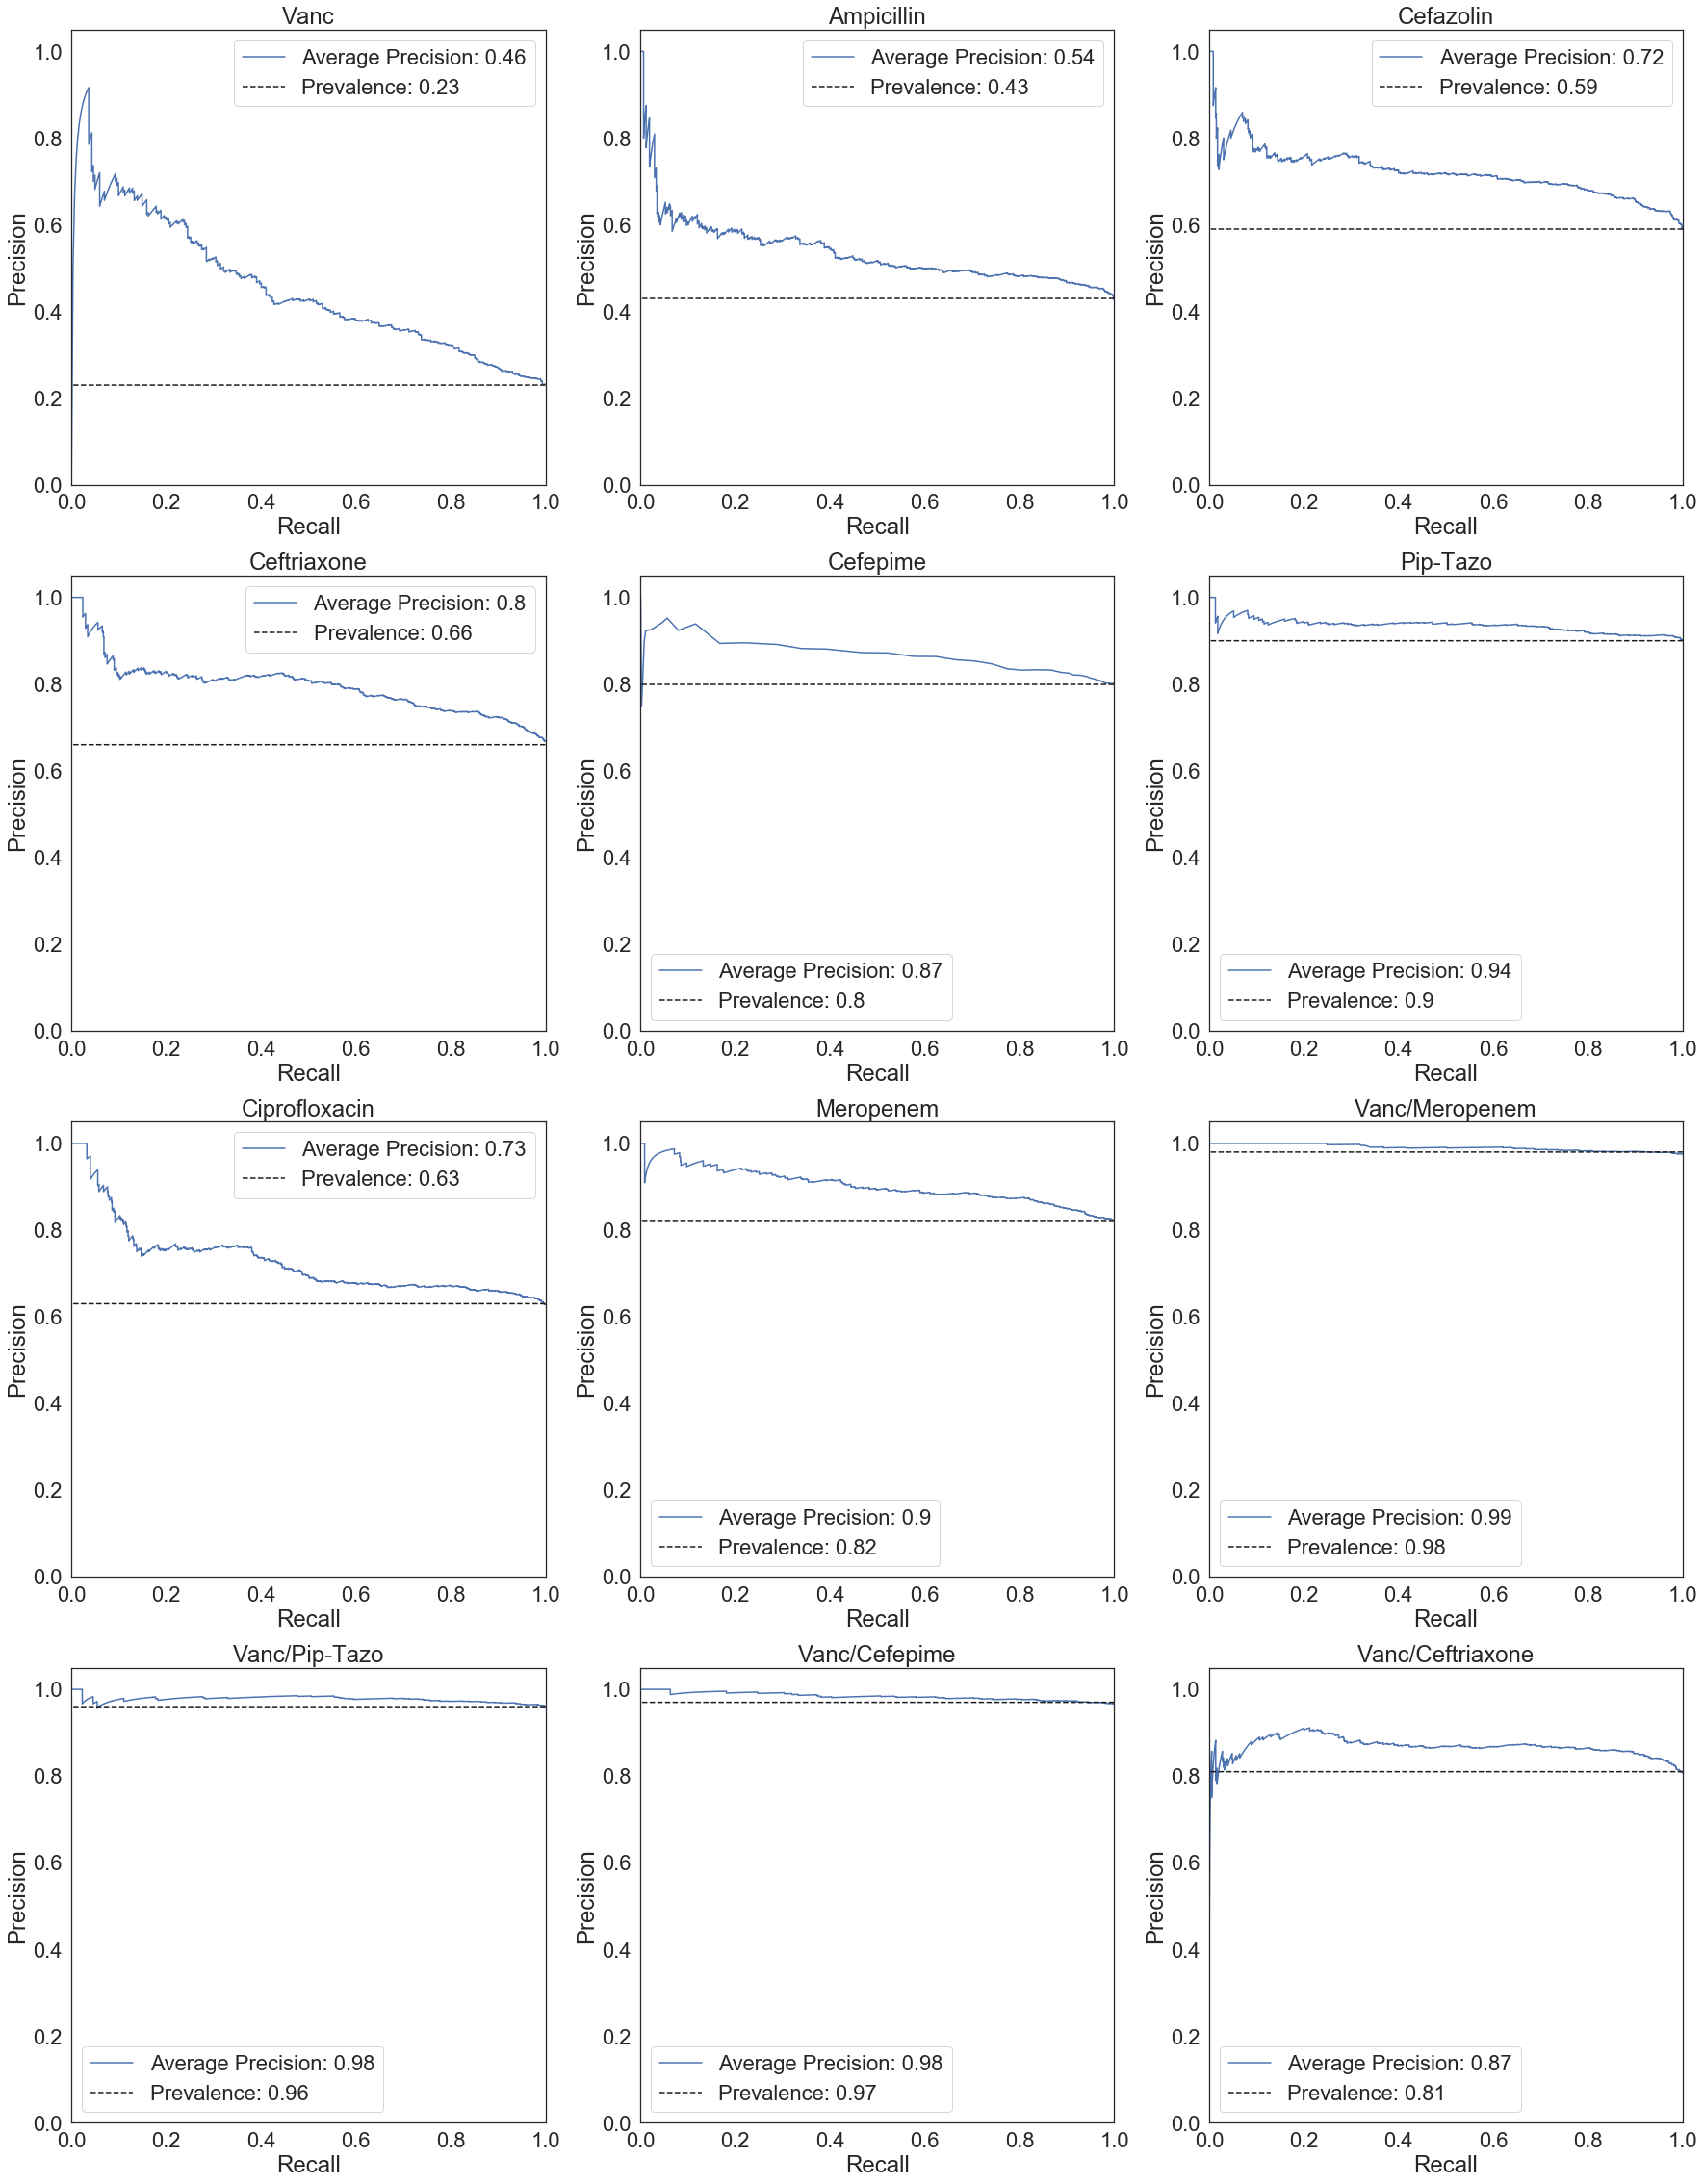

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=2.0)
from sklearn.metrics import precision_recall_curve

abbs = {
    "Ceftriaxone" : "Ceftriaxone",
    "Vancomycin_Zosyn" : "Vanc/Pip-Tazo",
    "Zosyn" : "Pip-Tazo",
    "Vancomycin_Ceftriaxone" : "Vanc/Ceftriaxone",
    "Vancomycin_Cefepime" : "Vanc/Cefepime",
    "Cefepime" : "Cefepime",
    "Vancomycin" : "Vanc",
    "Vancomycin_Meropenem" : "Vanc/Meropenem",
    "Meropenem" : "Meropenem",
    "Cefazolin" : "Cefazolin",
    "Ciprofloxacin" : "Ciprofloxacin",
    "Ampicillin" : "Ampicillin"
}


fig, axs = plt.subplots(4, 3, figsize=(30, 40))
row, col = 0, 0
for abx in abx_options:
    precision, recall, _ = precision_recall_curve(df['%s_label' % abx], df['%s_predictions' % abx])
    average_precision = average_precision_score(df['%s_label' % abx], df['%s_predictions' % abx])
    base_prev = round(np.average(df['%s_label' % abx].values), 2)
    axs[row, col].plot(recall, precision, label=f"Average Precision: {round(average_precision, 2)}")
    axs[row, col].plot(recall, [base_prev for r in recall], 'k--', label=f"Prevalence: {base_prev}")
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    axs[row, col].set_title(f"{abbs[abx]}")
    axs[row, col].set_xlabel('Recall')
    axs[row, col].set_ylabel('Precision')
    axs[row, col].legend()
    
    
    if col == 2:
        col = 0
        row += 1
    else:
        col +=1

plt.savefig(
    './precision_recall_curves.png',
    bbox_inches='tight',
    dpi=300
)
# plt.show()

### Now do this for the Boston Dataset

SXT best auc: 0.60325 best model: gbm
NIT best auc: 0.57413 best model: gbm
CIP best auc: 0.64089 best model: lasso
LVX best auc: 0.63747 best model: lasso


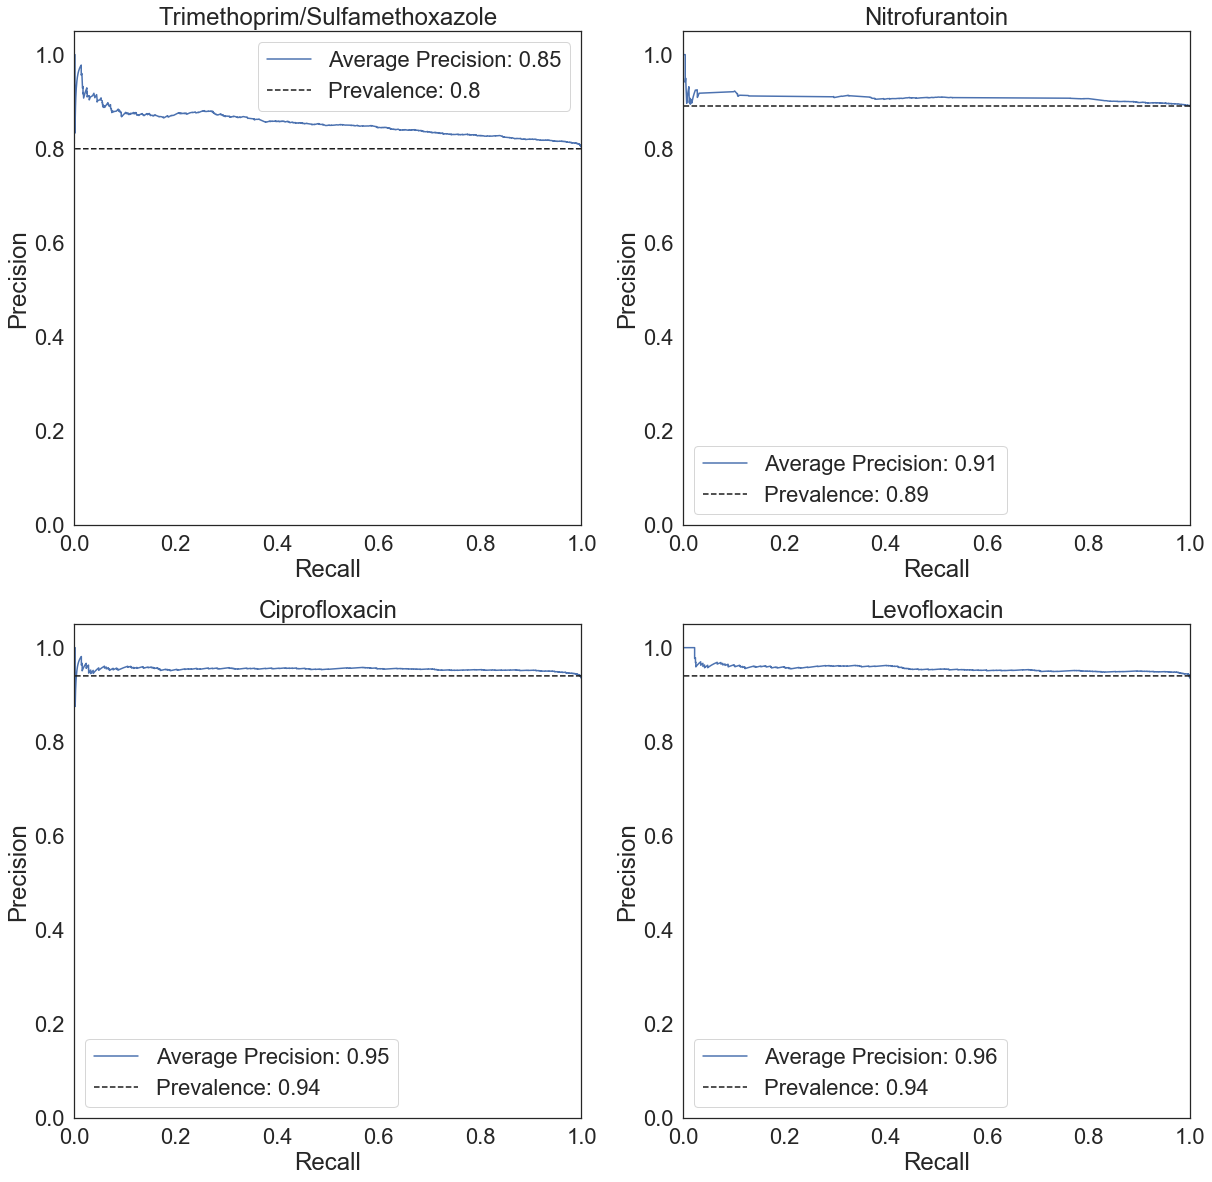

In [35]:
def load_predictions(base_path):
    best_auc = 0.5
    best_model = None
    label = base_path.split('/')[-1]
    for model in ['ridge', 'lasso', 'gbm', 'random_forest']:
        auc_path = os.path.join(base_path, model, "auroc.txt")
        with open(auc_path, 'r') as f:
            auc = float(f.read().rstrip())
        if auc > best_auc:
            # Load predictions for this model
            path = os.path.join(base_path, model, f"{model}_predictions.csv")
            df_preds = pd.read_csv(path)
            best_auc = auc
            best_model = model
    print(f"{label} best auc: {best_auc} best model: {best_model}")
    return df_preds, best_model

base_path = '/Users/conorcorbin/data/mit_abx_model_results/'
abbs = {
    'CIP' : 'Ciprofloxacin',
    'LVX' : 'Levofloxacin',
    'NIT' : 'Nitrofurantoin',
    'SXT' : 'Trimethoprim/Sulfamethoxazole'
}


fig, axs = plt.subplots(2, 2, figsize=(20, 20))
row, col = 0, 0
for abx in ['SXT', 'NIT', 'CIP', 'LVX']:
    df_preds, best_model = load_predictions(os.path.join(base_path, abx))
    labels = [1 if l == 0 else 0 for l in df_preds['label'].values]
    predictions = [1 - p for p in df_preds["predictions"].values]
    precision, recall, _ = precision_recall_curve(labels, predictions)
    average_precision = average_precision_score(labels, predictions)
    base_prev = round(np.mean(labels), 2)
    axs[row, col].plot(recall, precision, label=f"Average Precision: {round(average_precision, 2)}")
    axs[row, col].plot(recall, [base_prev for r in recall], 'k--', label=f"Prevalence: {base_prev}")
    axs[row, col].set_xlim([0.0, 1.0])
    axs[row, col].set_ylim([0.0, 1.05])
    axs[row, col].set_title(f"{abbs[abx]}")
    axs[row, col].set_xlabel('Recall')
    axs[row, col].set_ylabel('Precision')
    axs[row, col].legend()
    
    if col == 1:
        col = 0
        row += 1
    else:
        col +=1

plt.savefig(
    './precision_recall_curves_boston.png',
    bbox_inches='tight',
    dpi=300
)



### Test Set AUROC For Unseen patients vs patients that have been seen, and the two combined.  

In [ ]:
# Query set patients from train + val sets. 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/conorcorbin/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'mining-clinical-decisions' 
%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()

# Read in feature type dataframe so we can map to it
query="""
SELECT DISTINCT
    anon_id
FROM 
    `mining-clinical-decisions.abx.final_ast_labels`
WHERE 
    EXTRACT(YEAR FROM index_time) < 2019
"""
query_job = client.query(query)
df_training_pats = query_job.result().to_dataframe()

In [ ]:
train_val_pats = set(df_training_pats.anon_id.values)
len(train_val_pats)

In [ ]:
def bootstrapped_auroc(labels, predictions):
    """Given labels and predictions, bootstraps auroc and average precision
       and returns mean values along with 95%ci range for both of them"""
    
    aurocs = []
    inds = [i for i in range(len(labels))]
    print("Number of positive labels:{pos} Number of Labels:{total}".format(pos=str(labels.sum()),
                                                                            total=str(len(labels))))
    for i in range(1000):
        inds_boot = np.random.choice(inds, size=len(inds), replace=True)
        labels_b = labels[inds_boot]
        predictions_b = predictions[inds_boot]
        aurocs.append(roc_auc_score(labels_b, predictions_b))
    
    mean_auc = np.mean(aurocs)
    auc_low = np.percentile(aurocs, 2.5)
    auc_high = np.percentile(aurocs, 97.5)
    auroc = "%.2f [%.2f, %.2f]" % (mean_auc, auc_low, auc_high)

    return auroc

def stratified_bootstrapped_auroc(labels, predictions):
    """Given labels and predictions, bootstraps auroc and average precision
       and returns mean values along with 95%ci range for both of them"""
    
    df_hats = pd.DataFrame(data={
        'labels' : labels,
        'predictions' : predictions
    })
    
    aurocs = []
    inds = [i for i in range(len(labels))]
    print("Number of positive labels:{pos} Number of Labels:{total}".format(pos=str(labels.sum()),
                                                                            total=str(len(labels))))
    for i in range(1000):
        
        df_hats_boot = pd.DataFrame()
        for l in np.unique(labels):
            df_temp = (df_hats
                .query("labels == @l", engine='python')
                .sample(n=len(df_hats[df_hats['labels']==l]), replace=True)
            )
            df_hats_boot = pd.concat([df_hats_boot, df_temp])
        
        aurocs.append(roc_auc_score(df_hats_boot['labels'], df_hats_boot['predictions']))
    
    mean_auc = np.mean(aurocs)
    auc_low = np.percentile(aurocs, 2.5)
    auc_high = np.percentile(aurocs, 97.5)
    auroc = "%.2f [%.2f, %.2f]" % (mean_auc, auc_low, auc_high)
    
    return auroc



df_test_results = pd.DataFrame()
abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]

df_test_results['Antibiotic Selection'] = [a for a in abx_options]


base_path = "/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}"
aurocs_total, aurocs_repeat, aurocs_no_repeat = [], [], []
for abx in abx_options:
    print(abx)
    path = base_path.format(abx=abx)
    f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
    df = pd.read_csv(f_path)
    df_no_repeat_pats = (df
        .query("anon_id not in @train_val_pats", engine='python')
    )
    df_repeat_pats = (df
        .query("anon_id in @train_val_pats", engine='python')
    )
    print("Full")
    auroc_t = stratified_bootstrapped_auroc(df['label'].values,
                               df['predictions'].values)
    print("Repeat")
    aurocs_r = stratified_bootstrapped_auroc(df_repeat_pats['label'].values,
                                       df_repeat_pats['predictions'].values)
    print("No Repeat")
    aurocs_nr = stratified_bootstrapped_auroc(df_no_repeat_pats['label'].values,
                                          df_no_repeat_pats['predictions'].values)
    aurocs_total.append(auroc_t)
    aurocs_repeat.append(aurocs_r)
    aurocs_no_repeat.append(aurocs_nr)
    
df_test_results['AUROC All Observations'] = aurocs_total
df_test_results['AUROC Patients Seen In Training'] = aurocs_repeat
df_test_results['AUROC Patients Not Seen In Training'] = aurocs_no_repeat

In [ ]:
df_test_results

In [ ]:
df_test_results.to_csv('test_results_repeat_patients.csv', index=None)

### Get Classifier Performance Stratified By Various Demographic Factors
* Age Buckets, Sex, Race, Ethnicity 

In [ ]:
### Pull in Demographics for patients in the test set
query="""
WITH cohort AS (
SELECT DISTINCT
  anon_id, pat_enc_csn_id_coded, index_time
FROM
    `mining-clinical-decisions.abx.final_ast_labels`
WHERE 
    EXTRACT(YEAR FROM index_time) = 2019
),

adt_dep as (
SELECT DISTINCT
  adt.pat_enc_csn_id_coded, 
  FIRST_VALUE (dm.department_name) OVER 
  (PARTITION BY adt.pat_enc_csn_id_coded ORDER BY adt.effective_time_jittered_utc) department_name,
FROM 
  `shc_core.adt` adt
INNER JOIN
  `som-nero-phi-jonc101.shc_core.dep_map` dm
USING
  (department_id)
)

SELECT DISTINCT 
  dep.department_name,
  DATE_DIFF(CAST(c.index_time as DATE), d.BIRTH_DATE_JITTERED, year) age,
  c.pat_enc_csn_id_coded,
  d.ANON_ID, d.GENDER, d.CANONICAL_RACE, d.CANONICAL_ETHNICITY,
  CASE WHEN d.LANGUAGE = "English" THEN "English"
  ELSE "Non-English" END LANGUAGE,
  CASE WHEN d.INSURANCE_PAYOR_NAME = "MEDICARE" THEN "Medicare"
  WHEN d.INSURANCE_PAYOR_NAME = "MEDI-CAL" THEN "Medi-Cal"
  ELSE "Other" END INSURANCE_PAYOR_NAME,
FROM 
  `som-nero-phi-jonc101.shc_core.demographic` d
INNER JOIN
  cohort c
ON
  d.ANON_ID = c.anon_id
INNER JOIN
  adt_dep dep
ON
  c.pat_enc_csn_id_coded = dep.pat_enc_csn_id_coded
"""
query_job = client.query(query)
df_demographics = query_job.result().to_dataframe()

In [ ]:
df_demographics.head()

In [ ]:
df_demographics['age'].plot.hist()

In [ ]:
df_demographics.groupby('department_name').agg(num_observations=('pat_enc_csn_id_coded', 'nunique'))

In [ ]:
df_demo = (df_demographics
    .assign(department_name=lambda x: ['Stanford ED' if a != 'VCP EMERGENCY DEPARTMENT' else 'Valley Care ED'
                                       for a in x.department_name])
)
df_demo.head()

In [ ]:
df_demo.shape

In [ ]:
def _get_perf_by_strata(df, aurocs, column_name, name='race'):
    aurocs[name] = {}
    strata = df[column_name].unique()
    for s in strata:
        df_strata = df[df[column_name]==s]
        num_positive = df_strata['label'].sum()
        total = len(df_strata)
        # Check if we have at least one sample from each class
        if len(df_strata['label'].unique()) != 2:
            aurocs[name][s] = (num_positive, total, np.nan) # auroc undefined in this case
        else:
            auc = stratified_bootstrapped_auroc(df_strata['label'].values,
                                                df_strata['predictions'].values)
            aurocs[name][s] = (num_positive, total, auc)
    return aurocs

def get_performance_by_demographics(df):
    """With a pandas dataframe containing labels, predicitons, and variables to stratify over,
       computes performance measures over strata and retuns a table of AUROCS
    """
    aurocs = {}
    
    ### Get performance on all observations
    aurocs[''] = {}
    auc = stratified_bootstrapped_auroc(df['label'].values,
                                        df['predictions'].values)
    num_positive = df['label'].sum()
    total = len(df)
    aurocs['']['All Observations'] = (num_positive, total, auc)
    
    ### Get performance stratified by age buckets. We'll do 18-30, 31-50, 51-60, 61-70, 71-80, 81-90
    buckets = [(18, 30), (31, 50), (51, 60), (61, 70), (71, 80), (81, 90)]
    aurocs['Age'] = {}
    for age_bucket in buckets:
        df_age_bucket = (df
            .query("age >= @age_bucket[0] and age <= @age_bucket[1]", engine='python')
        )
        # Check if we have at least one sample from each class
        num_positive = df_age_bucket['label'].sum()
        total = len(df_age_bucket)
        if len(df_age_bucket['label'].unique()) != 2: 
            aurocs['Age'][age_bucket] = (num_positive, total, np.nan) # auroc undefined in this case
        else:
            auc = stratified_bootstrapped_auroc(df_age_bucket['label'].values,
                                                df_age_bucket['predictions'].values)
            aurocs['Age'][age_bucket] = (num_positive, total, auc)
        
        
    # Get Performance By Other Demographics
    aurocs = _get_perf_by_strata(df, aurocs, 'CANONICAL_RACE', name='Race')
    aurocs = _get_perf_by_strata(df, aurocs, 'department_name', name='Department ID')
    aurocs = _get_perf_by_strata(df, aurocs, 'GENDER', name='Sex')
    aurocs = _get_perf_by_strata(df, aurocs, 'CANONICAL_ETHNICITY', name='Ethnicity')
    aurocs = _get_perf_by_strata(df, aurocs, 'LANGUAGE', name='Language')
    aurocs = _get_perf_by_strata(df, aurocs, 'INSURANCE_PAYOR_NAME', name='Insurance Payer')
    
    
    return aurocs
    
base_path = "/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}"
os.makedirs('./results_by_demographics/', exist_ok=True)
for abx in abx_options:
    df_results = pd.DataFrame()
    print(abx)
    path = base_path.format(abx=abx)
    f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
    df = pd.read_csv(f_path)
    df_merged = df_demo.merge(df[['pat_enc_csn_id_coded', 'label', 'predictions']],
                            how='inner', on='pat_enc_csn_id_coded')
    aurocs = get_performance_by_demographics(df_merged)

    for strata_type in aurocs:
        df_results_temp = pd.DataFrame()
        df_results_temp['Stratified By'] = [strata_type for a in range(len(aurocs[strata_type]))]
        strata, num_pos, total, aucs = [], [], [], []
        for group in aurocs[strata_type]:
            strata.append(group)
            num_pos.append(aurocs[strata_type][group][0])
            total.append(aurocs[strata_type][group][1])
            aucs.append(aurocs[strata_type][group][2])

        df_results_temp['Group'] = strata
        df_results_temp['# Positive Examples'] = num_pos
        df_results_temp['# Total Examples'] = total
        df_results_temp['AUROC'] = aucs
        df_results = pd.concat([df_results, df_results_temp])

    # Write to csv
    df_results.to_csv(os.path.join('./results_by_demographics/', '%s_results_by_demographics.csv' % abx), index=None)

In [ ]:
df_results

In [ ]:
df_results = pd.DataFrame()
for strata_type in aurocs:
    df_results_temp = pd.DataFrame()
    df_results_temp['Stratified By'] = [strata_type for a in range(len(aurocs[strata_type]))]
    strata, aurocs = [], []
    for group in aurocs[strata_type]:
        strata.append(group)
        aurocs.append(aurocs[strata_type][group])

    df_results_temp['Group'] = strata
    df_results_temp['AUROC'] = aurocs
    df_results = pd.concat([df_results, df_results_temp])

df_results

## Validation Set Results
Create a table that has four rows for each antibiotic corresponding to model class.  We'll list AUROC on validation set and chosen hyperparameters.  

In [ ]:
import json
import pandas as pd
import glob, os
import pdb
import numpy as np
from sklearn.metrics import roc_auc_score
def bootstrapped_performance(labels, predictions):
    """Given labels and predictions, bootstraps auroc and average precision
       and returns mean values along with 95%ci range for both of them"""
    
    aurocs = []
    inds = [i for i in range(len(labels))]
    for i in range(1000):
        inds_boot = np.random.choice(inds, size=len(inds), replace=True)
        labels_b = labels[inds_boot]
        predictions_b = predictions[inds_boot]
        aurocs.append(roc_auc_score(labels_b, predictions_b))
    
    mean_auc = np.mean(aurocs)
    auc_low = np.percentile(aurocs, 2.5)
    auc_high = np.percentile(aurocs, 97.5)
    auroc = "%.2f [%.2f, %.2f]" % (mean_auc, auc_low, auc_high)
        
    return auroc


df_test_results = pd.DataFrame()
abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]



base_path = "/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/validation/{model}/{abx}"
model_class = []
prevs = []
aurocs = []
abxs = []
best_params_list = []
for abx in abx_options:
    for model in ['lasso', 'ridge', 'random_forest', 'lightgbm']:
        path = base_path.format(model=model, abx=abx)
        abxs.append(abx)
        model_class.append(model)
        f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
        df = pd.read_csv(f_path)
        auroc = bootstrapped_performance(df['label'].values,
                                         df['predictions'].values)
        aurocs.append(auroc)
        
        f_path = glob.glob(os.path.join(path, '*.json'))[0]
        with open(f_path) as f:
            best_params = json.load(f)
        best_params_list.append(best_params)


df_test_results['Antibiotic Selection'] = abxs
df_test_results['Model Class'] = model_class
df_test_results['AUROC'] = aurocs
df_test_results['Best Hyperparameters'] = best_params_list
df_test_results

In [ ]:
df_test_results.to_csv("Validation_results_bucket1.csv", index=None)

### Feature importances for test set classifiers

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/conorcorbin/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'mining-clinical-decisions' 
%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()

# Read in feature type dataframe so we can map to it
query="""
SELECT DISTINCT
    feature_type, features
FROM 
    `mining-clinical-decisions.abx.feature_counts_long`
WHERE 
    feature_type NOT IN ("Lab Results_val", "Flowsheet_val")
"""
query_job = client.query(query)
df_features = query_job.result().to_dataframe()

In [ ]:
abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]

base_path = "/Users/conorcorbin/repos/er_infection/results/ast_models_bucket1/testing/{abx}/"
feature_map_path = '/Users/conorcorbin/repos/er_infection/data/ast_models_bucket1/feature_vocabulary.csv'
df_feature_map = pd.read_csv(feature_map_path)
df_feature_imps = pd.DataFrame()
for abx in abx_options:
    path = base_path.format(abx=abx)
    fpath = glob.glob(os.path.join(path, '*importances.csv'))[0]
    df_imps = pd.read_csv(fpath)
    df_imps = (df_imps
        .merge(df_feature_map, how='inner', right_on='indices', left_on='feature_indices')
        .merge(df_features, how='left', on='features')
        .sort_values('feature_importances', ascending=False)
        .head(6) # Take top five only
    )
    df_imps['Antibiotic'] = [abx for i in range(len(df_imps))]
    df_imps['ModelClass'] = [fpath.split('/')[-1].split('_')[0] for i in range(len(df_imps))]
    df_imps = df_imps[['Antibiotic', 'ModelClass', 'features', 'feature_type']]
    df_feature_imps = pd.concat([df_feature_imps, df_imps])
df_feature_imps

In [ ]:
df_feature_imps.to_csv('feature_importances.csv', index=None)

In [ ]:
# Process table to make more clear
df_feature_imps = (df_feature_imps
    .assign(Antibiotic=lambda x: [a.replace('_', ' & ') for a in x.Antibiotic])
    .assign(ModelClass=lambda x: ['Gradient Boosted Tree' if a=='lightgbm' else 'Random Forest'
                                  for a in x.ModelClass])
    .assign(features=lambda x: ['Stanford ED' if a == 'PEDIATRIC EMERGENCY DEPARTMENT' else a
                                for a in x.features]) # pediatric and adult are the same thing and we see it coded as pediatric in our data even though its not
)
df_feature_imps

In [ ]:
df_feature_imps.to_csv('feature_importances.csv', index=None)